<!--BOOK_INFORMATION-->
<a href="https://www.packtpub.com/big-data-and-business-intelligence/machine-learning-opencv" target="_blank"><img align="left" src="data/cover.jpg" style="width: 76px; height: 100px; background: white; padding: 1px; border: 1px solid black; margin-right:10px;"></a>
*This notebook contains an excerpt from the book [Machine Learning for OpenCV](https://www.packtpub.com/big-data-and-business-intelligence/machine-learning-opencv) by Michael Beyeler.
The code is released under the [MIT license](https://opensource.org/licenses/MIT),
and is available on [GitHub](https://github.com/mbeyeler/opencv-machine-learning).*

*Note that this excerpt contains only the raw code - the book is rich with additional explanations and illustrations.
If you find this content useful, please consider supporting the work by
[buying the book](https://www.packtpub.com/big-data-and-business-intelligence/machine-learning-opencv)!*

<!--NAVIGATION-->
< [Building Our First Decision Tree](05.01-Building-Our-First-Decision-Tree.ipynb) | [Contents](../README.md) | [Using Decision Trees for Regression](05.03-Using-Decision-Trees-for-Regression.ipynb) >

# Using Decision Trees to Diagnose Breast Cancer

Now that we have built our first decision trees, it's time to turn our attention to a real dataset: The Breast Cancer Wisconsin dataset <https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)>.

In order to make the take feasible, the researchers performed feature extraction on the images, like we did in Chapter 4, Representing Data and Engineering Features. They went through a total of 569 images, and extracted 30 different features that describe the characteristics of the cell nuclei present in the images, including:

- cell nucleus texture (represented by the standard deviation of the gray-scale values)

- cell nucleus size (calculated as the mean of distances from center to points on the perimeter)

- tissue smoothness (local variation in radius lengths)

- tissue compactness

The goal of the research was then to classify tissue samples into benign and malignant (a binary classification task).

## Loading the dataset

The full dataset is part of Scikit-Learn's example datasets:

In [1]:
from sklearn import datasets
data = datasets.load_breast_cancer()

As in previous examples, all data is contained in a 2-D feature matrix data.data, where the rows represent data samples, and the columns are the feature values:

In [2]:
data.data.shape

(569, 30)

With a look at the provided feature names, we recognize some that we mentioned above:

In [3]:
data.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'], 
      dtype='<U23')

Since this is a binary classification task, we expect to find exactly two target names:

In [4]:
data.target_names

array(['malignant', 'benign'], 
      dtype='<U9')

Let's split the dataset into training and test sets using a healthy 80-20 split:

In [5]:
import sklearn.model_selection as ms
X_train, X_test, y_train, y_test = ms.train_test_split(data.data, data.target, test_size=0.2, random_state=42)

In [6]:
X_train.shape, X_test.shape

((455, 30), (114, 30))

## Building the decision tree

In [7]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier(random_state=42)

In [8]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

Since we did not specify any pre-pruning parameters, we would expect this decision tree to grow quite large and result in a perfect score on the training set:

In [9]:
dtc.score(X_train, y_train)

1.0

However, to our surprise, the test error is not too shabby, either:

In [10]:
dtc.score(X_test, y_test)

0.94736842105263153

In [11]:
with open("tree.dot", 'w') as f:
    f = tree.export_graphviz(dtc, out_file=f,
                             feature_names=data.feature_names,
                             class_names=data.target_names)

Now we want to do some model exploration. For example, we mentioned above that the depth of a tree influences its performance. If we wanted to study this dependency more systematically, we could repeat building the tree for different values of `max_depth`:

In [12]:
import numpy as np
max_depths = np.array([1, 2, 3, 5, 7, 9, 11])

For each of these values, we want to run the full model cascade from start to finish. We also want to record the train and test scores. We do this in a for loop:

In [13]:
train_score = []
test_score = []
for d in max_depths:
    dtc = tree.DecisionTreeClassifier(max_depth=d, random_state=42)
    dtc.fit(X_train, y_train)
    train_score.append(dtc.score(X_train, y_train))
    test_score.append(dtc.score(X_test, y_test))

We can plot the scores as a function of the tree depth using Matplotlib:

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

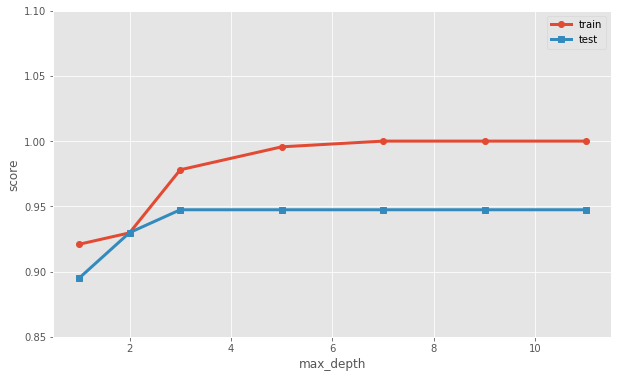

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_score, 'o-', linewidth=3, label='train')
plt.plot(max_depths, test_score, 's-', linewidth=3, label='test')
plt.xlabel('max_depth')
plt.ylabel('score')
plt.ylim(0.85, 1.1)
plt.legend()

Let's do one more. What about the minimum numbers of samples required to make a node a leaf node?

We repeat the procedure from above:

In [16]:
train_score = []
test_score = []
min_samples = np.array([2, 4, 8, 16, 32])
for s in min_samples:
    dtc = tree.DecisionTreeClassifier(min_samples_leaf=s, random_state=42)
    dtc.fit(X_train, y_train)
    train_score.append(dtc.score(X_train, y_train))
    test_score.append(dtc.score(X_test, y_test))

This leads to a plot that looks quite different from the one before:

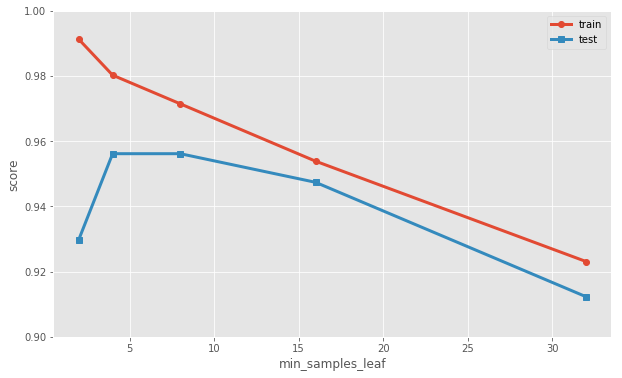

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(min_samples, train_score, 'o-', linewidth=3, label='train')
plt.plot(min_samples, test_score, 's-', linewidth=3, label='test')
plt.xlabel('min_samples_leaf')
plt.ylabel('score')
plt.ylim(0.9, 1)
plt.legend()

What does this all mean? Refer to Chapter 5 for the answers.

<!--NAVIGATION-->
< [Building Our First Decision Tree](05.01-Building-Our-First-Decision-Tree.ipynb) | [Contents](../README.md) | [Using Decision Trees for Regression](05.03-Using-Decision-Trees-for-Regression.ipynb) >